In [2]:
! pip install cplex
! apt install coinor-libipopt-dev
! pip install ipopt

     |████████████████████████████████| 30.9MB 136kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  coinor-libipopt1v5 libmumps-5.1.2 libmumps-dev libmumps-seq-5.1.2
  libmumps-seq-dev libscalapack-mpi-dev libscalapack-openmpi-dev
  libscalapack-openmpi2.0 libscotch-6.0
Suggested packages:
  scalapack-doc
The following NEW packages will be installed:
  coinor-libipopt-dev coinor-libipopt1v5 libmumps-5.1.2 libmumps-dev
  libmumps-seq-5.1.2 libmumps-seq-dev libscalapack-mpi-dev
  libscalapack-openmpi-dev libscalapack-openmpi2.0 libscotch-6.0
0 upgraded, 10 newly installed, 0 to remove and 29 not upgraded.
Need to get 7,515 kB of archives.
After this operation, 50.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libscalapack-openmpi2.0 amd64 2.0.2-4 [1,473 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libmumps

# 2019-2020


Initial portfolio value = $ 1000070.06


Period 1: start date 01/02/2019, end date 02/28/2019
  Strategy "Buy and Hold", value begin = $ 1000070.06, value end = $ 1121179.83
  Strategy "Equally Weighted Portfolio", value begin = $ 991124.38, value end = $ 1097031.81
  Strategy "Minimum Variance Portfolio", value begin = $ 991702.28, value end = $ 1057440.44
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990119.39, value end = $ 1016524.41
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 991476.17, value end = $ 1085213.31
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 983596.64, value end = $ 1171994.21
  Strategy "Robust Optimization Portfolio", value begin = $ 1000070.06, value end = $ 1121179.83

Period 2: start date 03/01/2019, end date 04/30/2019
  Strategy "Buy and Hold", value begin = $ 1126131.27, value end = $ 1075001.89
  Strategy "Equally Weighted Portfolio", value begin = $ 1103260.47, value end = $ 1188731.33
  Str

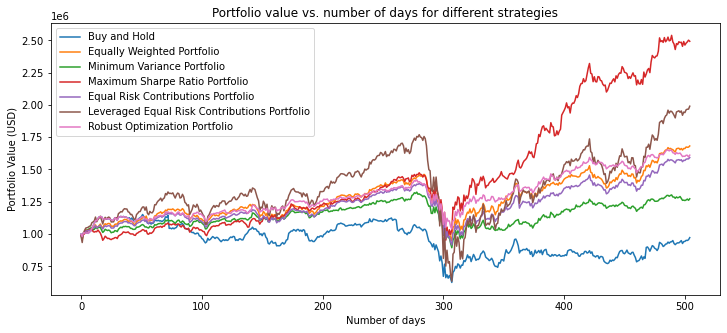

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex 
import ipopt
import matplotlib.pyplot as plt

# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
   x_optimal = x_init
   cash_optimal = cash_init
   pay_back=0
   return x_optimal, cash_optimal,pay_back

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    # Calculate current portfolio value
    cur_portf_value = np.dot(cur_prices,x_init) + cash_init
    # Calculate positions and round down to nearest integer
    x_optimal = np.floor(cur_portf_value/(20*cur_prices))
    # Calculate transaction cost
    transaction_cost = np.dot(cur_prices,np.abs(x_optimal-x_init))*0.005
    # Calculate cash remained in account
    cash_optimal = cur_portf_value - np.dot(cur_prices,x_optimal) - transaction_cost
    pay_back=0

    return x_optimal, cash_optimal,pay_back

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    n = 20
    c = np.zeros((n))
    lb = np.zeros((n))
    ub = np.ones((n))
    A = []
    for k in range(n):
        A.append([[0],[1]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1], senses="E")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(qmat)
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    # Get w from solver
    w_min_variance = np.array(cpx.solution.get_values())
    # Calculate current portfolio value
    cur_portf_value = np.dot(cur_prices,x_init) + cash_init
    # Calculate positions and round down to neartest integer
    x_optimal = np.floor((cur_portf_value*w_min_variance)/cur_prices)
    # Calculate transaction cost
    transaction_cost = np.dot(cur_prices,np.abs(x_optimal-x_init))*0.005
    # Calculate cash left in account
    cash_optimal = cur_portf_value - np.dot(cur_prices,x_optimal) - transaction_cost
    pay_back=0
    return x_optimal, cash_optimal,pay_back

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    n = 21
    c = np.zeros((n))
    lb = np.zeros((n))
    ub = [cplex.infinity]*n
    # Risk-free return is converted to daily
    coef = mu-r_rf/252
    A = []
    for k in range(n-1):
        A.append([[0,1],[coef[k],1,0]])
    A.append([[1],[-1]])
    # First 20 variables are y
    var_names = ["y_%s" % i for i in range(1,n)]
    # Last variable is kappa
    var_names.append('kappa')
    cpx.linear_constraints.add(rhs=[1,0], senses="EE")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    # Adjust Q so that it has shape of (21,21)
    Q=np.hstack((Q,np.zeros((20,1))))
    Q=np.vstack((Q,np.zeros((1,21))))
    qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(qmat)
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    if cpx.solution.get_status_string()== 'infeasible':
        x_optimal = x_init
        cash_optimal = cash_init
    else:
        # Get optimal solution from solver
        solution = np.array(cpx.solution.get_values())
        # Get the value for y
        y = solution[:20]
        # Get the value for kappa
        kappa = solution[20]
        # Calculate w using formula: w=y/k
        w_max_sharpe = y/kappa
        # Calculate current portfolio value
        cur_portf_value = np.dot(cur_prices,x_init) + cash_init
        # Calculate positions and round down to nearest integer
        x_optimal = np.floor((cur_portf_value*w_max_sharpe)/cur_prices)
        # Calculate transaction cost
        transaction_cost = np.dot(cur_prices,np.abs(x_optimal-x_init))*0.005
        # Calculate cash left in account
        cash_optimal = cur_portf_value - np.dot(cur_prices,x_optimal) - transaction_cost
    pay_back=0
    return x_optimal, cash_optimal,pay_back

# Define a class for ERC problem
class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        n=20
        for i in range(n):
            for j in range(i,n):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval

    def gradient(self, x):
        n=20
        # The callback for calculating the gradient
        grad = np.zeros(n)
        # Insert your gradient computations here
        # You can use finite differences to check the gradient
        y = x * np.dot(Q,x)

        for i in range(n):
            for j in range(i,n):
                grad1 = Q[i,i]*x[i] + np.dot(Q,x)[i]
                grad2 = -(Q[j,j]*x[j] + np.dot(Q,x)[j])
                g1 = (y[i]-y[j]) * grad1
                g2=(y[i]-y[j])*grad2
                grad[i] = grad[i] + g1
                grad[j]=grad[j]+g2

        grad = 4 *  grad
        return grad

    def constraints(self, x):
        # The callback for calculating the constraints
        n=20
        return [1.0] * n
    
    def jacobian(self, x):
        # The callback for calculating the Jacobian
        n=20
        return np.array([[1.0] * n])

def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    n=20
    w0=(x_init*cur_prices)/(np.dot(x_init,cur_prices)+cash_init)
    lb = [0]*n
    ub=[1]*n
    cl=[1]
    cu=[1]
    # Define IPOPT problem
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)
    # Solve the problem
    w_erc, info = nlp.solve(w0)
    # Calculate current portfolio value
    cur_portf_value = np.dot(cur_prices,x_init) + cash_init
    # Calculate positions and round down to nearest integer
    x_optimal = np.floor((cur_portf_value*w_erc)/cur_prices)
    # Calculate transaction cost
    transaction_cost = np.dot(cur_prices,np.abs(x_optimal-x_init))*0.005
    # Calculate cash left in account
    cash_optimal = cur_portf_value - np.dot(cur_prices,x_optimal) - transaction_cost
    pay_back=0
    return x_optimal, cash_optimal,pay_back

def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    # Get the position for strategy 5 in the same period
    erc_positions = x[4,period-1]
    # Get the cash for strategy 5 in the same period
    erc_cash = cash[4,period-1]
    # Calcualte the weights for strategy 5 in the same period
    erc_weights = (erc_positions*cur_prices)/(np.dot(erc_positions,cur_prices)+erc_cash)
    # Calcualte portfolio weights from last period
    w0=(x_init*cur_prices)/(np.dot(x_init,cur_prices)+cash_init)
    # Get the loan from previous period
    pb=loan[5,period-1]
    # Calculate how many positions need to sell
    x_sell = np.ceil(pb*w0/cur_prices)
    # Calculate positions after selling
    new_x=x_init-x_sell
    # Calculate transaction cost needs to pay for the selling
    transaction_cost1=np.dot(cur_prices,x_sell)*0.005
    # Calcualte cash left in hand after paying the loan
    temp_cash = np.dot(x_sell,cur_prices)-pb
    # Calcualte portfolio value after paying the loan and transaction cost
    cur_portf_value = np.dot(cur_prices,x_init)+cash_init-transaction_cost1-pb+temp_cash
    # Double the portfolio value
    lever_portf_value = 2*cur_portf_value
    # Calcualte positions and round down to the nearest integer
    x_optimal = np.floor((lever_portf_value*erc_weights)/cur_prices)
    # Calcualte the transactio cost needs to pay for buying positions
    transaction_cost2 = np.dot(cur_prices,np.abs(x_optimal-new_x))*0.005
    # Calcualte the cash left in the account
    cash_optimal = lever_portf_value-np.dot(cur_prices,x_optimal)-transaction_cost2
    # Calcualte interest need to pay for two months
    interest = cur_portf_value*(r_rf/6)
    # Calculate how much need to pay in next period
    pay_back = interest+cur_portf_value

    return x_optimal, cash_optimal,pay_back

def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    n = 20
    c = np.zeros((n))
    lb = np.zeros((n))
    ub = np.ones((n))
    A = []
    for k in range(n):
        A.append([[0,1],[1,mu[k]]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1,2*r_rf/252], senses="EG")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    theta=np.diag(np.diag(Q))
    w0=(x_init*cur_prices)/(np.dot(x_init,cur_prices)+cash_init)
    rob_bnd=0.8*np.dot(w0,np.dot(theta,w0))
    cpx.objective.set_quadratic(qmat)
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(theta))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    cpx.solve()
    if cpx.solution.get_status_string()== 'infeasible':
        x_optimal = x_init
        cash_optimal = cash_init
    else:
        # Get w from solver
        w_rob_portf = np.array(cpx.solution.get_values())
        # Calculate current portfolio value
        cur_portf_value = np.dot(cur_prices,x_init) + cash_init
        # Calculate positions and round down to neartest integer
        x_optimal = np.floor((cur_portf_value*w_rob_portf)/cur_prices)
        # Calculate transaction cost
        transaction_cost = np.dot(cur_prices,np.abs(x_optimal-x_init))*0.005
        # Calculate cash left in account
        cash_optimal = cur_portf_value - np.dot(cur_prices,x_optimal) - transaction_cost
    pay_back=0
    return x_optimal, cash_optimal,pay_back

# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2018 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2018)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2018
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 980, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20000])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2019-2020 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
loan=np.zeros((N_strat, N_periods+1),  dtype=np.ndarray)
for period in range(1, N_periods+1):
    # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 19:
        cur_year  = 19 + math.floor(period/7)
    else:
        cur_year  = 2019 + math.floor(period/7)
    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]
    # Execute portfolio selection strategies
    for strategy  in range(N_strat):
        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]
       
        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1],loan[strategy,period] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs
        ###################### Insert your code here ############################
        # Logic: If the account value is not enough for portfolio adjustment and transaction cost
        #            then the unit of shares for each stock must be reduced
        # Check if cash account is negative and make adjustment
        # For strategies other than 5
        if strategy != 5:
            while cash[strategy, period-1] < 0:
                # Calcualte the position ratio
                x_ratio = x[strategy,period-1]/np.sum(x[strategy,period-1])
                # Distribute cash based on position ratio
                cash_distribute = -cash[strategy, period-1]*x_ratio
                # Calculate number of units need to be reduced and round it up to nearest integer
                x_reduce = np.ceil(cash_distribute/cur_prices)
                # Replace with adjusted position
                x[strategy, period-1] = x[strategy, period-1] - x_reduce
                # Calculate current portfolio value
                cur_portfolio_value = np.dot(curr_positions,cur_prices) + curr_cash
                # Calculate transaction cost using adjusted position
                transaction_cost = np.dot(cur_prices,np.abs(x[strategy, period-1]-curr_positions))*0.005
                # Calculate cash remained in account after adjustment
                cash[strategy, period-1] = cur_portfolio_value - np.dot(cur_prices, x[strategy, period-1]) - transaction_cost
        # For strategy 5
        else:
            while cash[strategy, period-1] < 0:
                # Calcualte the position ratio
                x_ratio = x[strategy,period-1]/np.sum(x[strategy,period-1])
                # Distribute cash based on position ratio
                cash_distribute = -cash[strategy, period-1]*x_ratio
                # Calculate number of units need to be reduced and round it up to nearest integer
                x_reduce = np.ceil(cash_distribute/cur_prices)
                # Replace with adjusted position
                x[strategy, period-1] = x[strategy, period-1] - x_reduce
                # Repeat the calculation in strategy 5's function
                erc_positions = x[4,period-1]
                erc_cash = cash[4,period-1]
                erc_weights = (erc_positions*cur_prices)/(np.dot(erc_positions,cur_prices)+erc_cash)
                pb=loan[5,period-1]
                x_sell = np.ceil(pb/(20*cur_prices))
                new_x=curr_positions-x_sell
                transaction_cost1=np.dot(cur_prices,x_sell)*0.005
                cur_portf_value = np.dot(cur_prices,curr_positions)+curr_cash-transaction_cost1-pb
                lever_portf_value = 2*cur_portf_value
                # Calculate transaction cost using adjusted positions
                transaction_cost2 = np.dot(cur_prices,np.abs(x[strategy,period-1]-new_x))*0.005
                # Calculate cash left in the account
                cash[strategy, period-1] = lever_portf_value-np.dot(cur_prices,x[strategy,period-1])-transaction_cost2
        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]-loan[strategy,period]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
    # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)

# Plot results
###################### Insert your code here ############################
plt.figure(figsize=(12,5))
for i in range(7):
    plt.plot(portf_value[i],label=strategy_names[i])
plt.legend()
plt.xlabel('Number of days')
plt.ylabel('Portfolio Value (USD)')
plt.title('Portfolio value vs. number of days for different strategies')
plt.show()

Text(0.5, 1.0, 'Maximum drawdown in each period for each strategy')

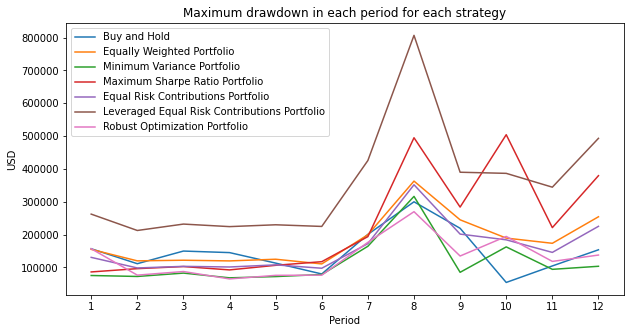

In [6]:
# Plot maximum drawdowns
plt.figure(figsize=(10,5))
plt.xticks(range(1,13))
for i in range(7):
    v=portf_value[i]
    result_list=[]
    for period in range(1, N_periods+1):
        # Compute current year and month, first and last day of the period
        if dates_array[0, 0] == 19:
            cur_year  = 19 + math.floor(period/7)
        else:
            cur_year  = 2019 + math.floor(period/7)
        cur_month = 2*((period-1)%6) + 1
        day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
        day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
        # Get the portfolio value in the period
        period_v=np.array(v[day_ind_start:day_ind_end,:])
        # Maximum value - minimum value
        result_list.append(period_v.max()-period_v.min())
    plt.plot(range(1,13),result_list,label=strategy_names[i])
plt.legend()
plt.xlabel('Period')
plt.ylabel('USD')
plt.title('Maximum drawdown in each period for each strategy')



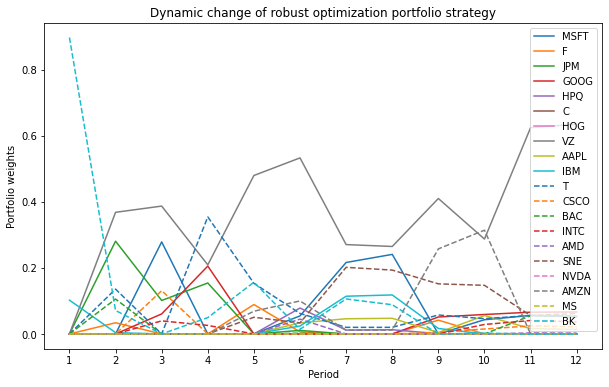

In [7]:
# Plot dynamic change in portfolio allocation for robust optimization portfolio
positions_rob_opt = x[6]
result_list=[]
stock_code = df.columns[1:]
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 19:
        cur_year  = 19 + math.floor(period/7)
    else:
        cur_year  = 2019 + math.floor(period/7)
    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   
   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]
    # Apply formula: wi=(vi)(xi)/V
    portf_weight = positions_rob_opt[period-1]*cur_prices/portf_value[6][day_ind_start]
    result_list.append(portf_weight)
# Transpose the result so that rows are stocks and columns are periods
result_array=np.array(result_list).T
plt.figure(figsize=(10,6))
for j in range(20):
    if j > 9:
        plt.plot(range(1,13),result_array[j],label=stock_code[j],linestyle='dashed')
    else:
        plt.plot(range(1,13),result_array[j],label=stock_code[j])
plt.legend(loc='upper right')
plt.xticks(range(1,13))
plt.xlabel('Period')
plt.ylabel('Portfolio weights')
plt.title('Dynamic change of robust optimization portfolio strategy')
plt.show()

# 2008-2009


Initial portfolio value = $ 789230.94


Period 1: start date 01/02/2008, end date 02/29/2008
  Strategy "Buy and Hold", value begin = $ 789230.94, value end = $ 749509.71
  Strategy "Equally Weighted Portfolio", value begin = $ 782163.77, value end = $ 669696.11
  Strategy "Minimum Variance Portfolio", value begin = $ 781380.14, value end = $ 666675.23
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 781378.15, value end = $ 681744.86
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 782222.09, value end = $ 670364.43
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 773006.32, value end = $ 548465.15
  Strategy "Robust Optimization Portfolio", value begin = $ 781380.17, value end = $ 662488.43

Period 2: start date 03/03/2008, end date 04/30/2008
  Strategy "Buy and Hold", value begin = $ 754361.26, value end = $ 752687.89
  Strategy "Equally Weighted Portfolio", value begin = $ 659796.35, value end = $ 726864.96
  Strategy "Minimum

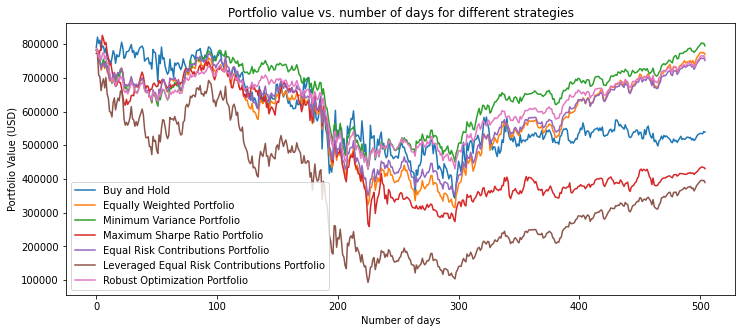

In [8]:
# Input file
input_file_prices = 'Daily_closing_prices20082009.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)
dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2007 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)
# Remove datapoints for year 2007
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 980, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20000])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)


# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
loan=np.zeros((N_strat, N_periods+1),  dtype=np.ndarray)
for period in range(1, N_periods+1):
    # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 8:
        cur_year  = 8 + math.floor(period/7)
    else:
        cur_year  = 2008 + math.floor(period/7)
    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]
    # Execute portfolio selection strategies
    for strategy  in range(N_strat):
        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]
       
        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1],loan[strategy,period] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs
        ###################### Insert your code here ############################
        # Logic: If the account value is not enough for portfolio adjustment and transaction cost
        #            then the unit of shares for each stock must be reduced
        # Check if cash account is negative and make adjustment
        # For strategies other than 5
        if strategy != 5:
            while cash[strategy, period-1] < 0:
                # Calcualte the position ratio
                x_ratio = x[strategy,period-1]/np.sum(x[strategy,period-1])
                # Distribute cash based on position ratio
                cash_distribute = -cash[strategy, period-1]*x_ratio
                # Calculate number of units need to be reduced and round it up to nearest integer
                x_reduce = np.ceil(cash_distribute/cur_prices)
                # Replace with adjusted position
                x[strategy, period-1] = x[strategy, period-1] - x_reduce
                # Calculate current portfolio value
                cur_portfolio_value = np.dot(curr_positions,cur_prices) + curr_cash
                # Calculate transaction cost using adjusted position
                transaction_cost = np.dot(cur_prices,np.abs(x[strategy, period-1]-curr_positions))*0.005
                # Calculate cash remained in account after adjustment
                cash[strategy, period-1] = cur_portfolio_value - np.dot(cur_prices, x[strategy, period-1]) - transaction_cost
        # For strategy 5
        else:
            while cash[strategy, period-1] < 0:
                # Calcualte the position ratio
                x_ratio = x[strategy,period-1]/np.sum(x[strategy,period-1])
                # Distribute cash based on position ratio
                cash_distribute = -cash[strategy, period-1]*x_ratio
                # Calculate number of units need to be reduced and round it up to nearest integer
                x_reduce = np.ceil(cash_distribute/cur_prices)
                # Replace with adjusted position
                x[strategy, period-1] = x[strategy, period-1] - x_reduce
                # Repeat the calculation in strategy 5's function
                erc_positions = x[4,period-1]
                erc_cash = cash[4,period-1]
                erc_weights = (erc_positions*cur_prices)/(np.dot(erc_positions,cur_prices)+erc_cash)
                pb=loan[5,period-1]
                x_sell = np.ceil(pb/(20*cur_prices))
                new_x=curr_positions-x_sell
                transaction_cost1=np.dot(cur_prices,x_sell)*0.005
                cur_portf_value = np.dot(cur_prices,curr_positions)+curr_cash-transaction_cost1-pb
                lever_portf_value = 2*cur_portf_value
                # Calculate transaction cost using adjusted positions
                transaction_cost2 = np.dot(cur_prices,np.abs(x[strategy,period-1]-new_x))*0.005
                # Calculate cash left in the account
                cash[strategy, period-1] = lever_portf_value-np.dot(cur_prices,x[strategy,period-1])-transaction_cost2
        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]-loan[strategy,period]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
    # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)

# Plot results
###################### Insert your code here ############################
plt.figure(figsize=(12,5))
for i in range(7):
    plt.plot(portf_value[i],label=strategy_names[i])
plt.legend()
plt.xlabel('Number of days')
plt.ylabel('Portfolio Value (USD)')
plt.title('Portfolio value vs. number of days for different strategies')
plt.show()

Text(0.5, 1.0, 'Maximum drawdown in each period for each strategy')

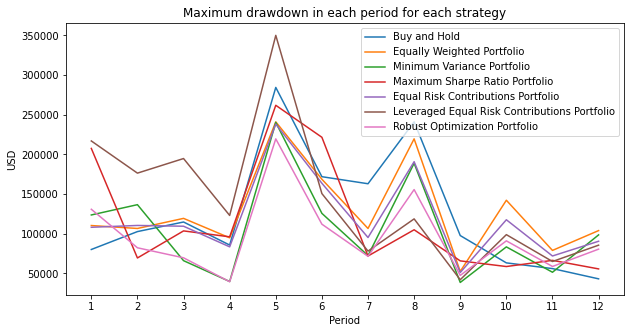

In [9]:
# Plot maximum drawdowns
plt.figure(figsize=(10,5))
plt.xticks(range(1,13))
for i in range(7):
    v=portf_value[i]
    result_list=[]
    for period in range(1, N_periods+1):
        # Compute current year and month, first and last day of the period
        if dates_array[0, 0] == 8:
            cur_year  = 8 + math.floor(period/7)
        else:
            cur_year  = 2008 + math.floor(period/7)
        cur_month = 2*((period-1)%6) + 1
        day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
        day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
        period_v=np.array(v[day_ind_start:day_ind_end,:])
        result_list.append(period_v.max()-period_v.min())
    plt.plot(range(1,13),result_list,label=strategy_names[i])
plt.legend()
plt.xlabel('Period')
plt.ylabel('USD')
plt.title('Maximum drawdown in each period for each strategy')

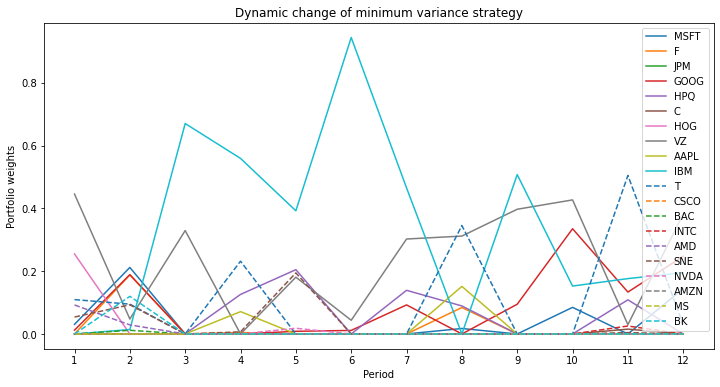

In [10]:
# Plot dynamic change in portfolio allocation for minimum variance strategy
positions_min_val = x[2]
result_list=[]
stock_code = df.columns[1:]
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 8:
        cur_year  = 8 + math.floor(period/7)
    else:
        cur_year  = 2008 + math.floor(period/7)
    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   
   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]
    # Apply formula: wi=(vi)(xi)/V
    portf_weight = positions_min_val[period-1]*cur_prices/portf_value[2][day_ind_start]
    result_list.append(portf_weight)
# Transpose the result so that rows are stocks and columns are periods
result_array=np.array(result_list).T
plt.figure(figsize=(12,6))
for j in range(20):
    if j > 9:
        plt.plot(range(1,13),result_array[j],label=stock_code[j],linestyle='dashed')
    else:
        plt.plot(range(1,13),result_array[j],label=stock_code[j])
plt.legend(loc='upper right')
plt.xticks(range(1,13))
plt.xlabel('Period')
plt.ylabel('Portfolio weights')
plt.title('Dynamic change of minimum variance strategy')
plt.show()

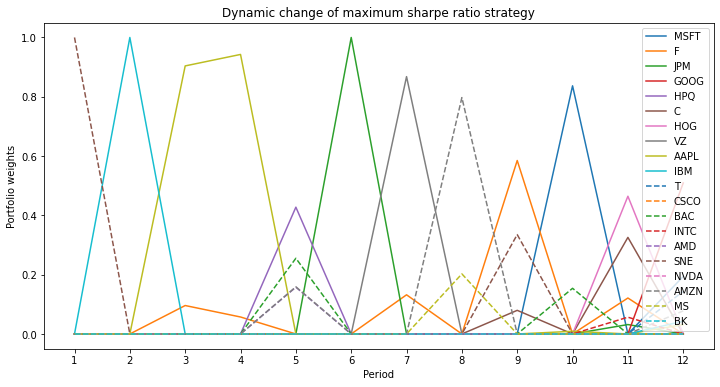

In [11]:
# Plot dynamic change in portfolio allocation for Maximum Sharpe Ratio strategy
positions_max_sharpe = x[3]
result_list=[]
stock_code = df.columns[1:]
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 8:
        cur_year  = 8 + math.floor(period/7)
    else:
        cur_year  = 2008 + math.floor(period/7)
    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   
   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]
    # Apply formula: wi=(vi)(xi)/V
    portf_weight = positions_max_sharpe[period-1]*cur_prices/portf_value[3][day_ind_start]
    result_list.append(portf_weight)
# Transpose the result so that rows are stocks and columns are periods
result_array=np.array(result_list).T
plt.figure(figsize=(12,6))
for j in range(20):
    if j > 9:
        plt.plot(range(1,13),result_array[j],label=stock_code[j],linestyle='dashed')
    else:
        plt.plot(range(1,13),result_array[j],label=stock_code[j])
plt.legend(loc='upper right')
plt.xticks(range(1,13))
plt.xlabel('Period')
plt.ylabel('Portfolio weights')
plt.title('Dynamic change of maximum sharpe ratio strategy')
plt.show()

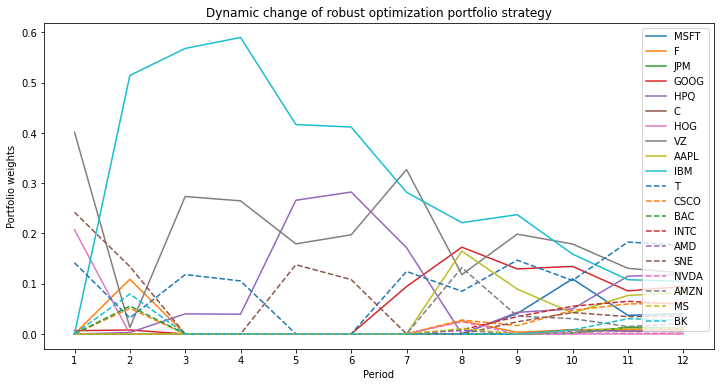

In [12]:
# Plot dynamic change in portfolio allocation for robust optimization portfolio
positions_rob_opt = x[6]
result_list=[]
stock_code = df.columns[1:]
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 8:
        cur_year  = 8 + math.floor(period/7)
    else:
        cur_year  = 2008 + math.floor(period/7)
    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   
   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]
    # Apply formula: wi=(vi)(xi)/V
    portf_weight = positions_rob_opt[period-1]*cur_prices/portf_value[6][day_ind_start]
    result_list.append(portf_weight)
# Transpose the result so that rows are stocks and columns are periods
result_array=np.array(result_list).T
plt.figure(figsize=(12,6))
for j in range(20):
    if j > 9:
        plt.plot(range(1,13),result_array[j],label=stock_code[j],linestyle='dashed')
    else:
        plt.plot(range(1,13),result_array[j],label=stock_code[j])
plt.legend(loc='upper right')
plt.xticks(range(1,13))
plt.xlabel('Period')
plt.ylabel('Portfolio weights')
plt.title('Dynamic change of robust optimization portfolio strategy')
plt.show()